In [28]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')
data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,weather_group,hour_sin,hour_cos,month_sin,month_cos,humidity_change,pressure_trend_6h,press_std_12h,hum_max_6h,temp_diff_3h
0,25.2,81,21.6,1015.5,65,11.9,Drizzle,2.588190e-01,-0.965926,0.5,0.866025,-1.0,1.6,1.059553,92.0,1.7
1,25.3,80,21.6,1014.9,93,14.2,Drizzle,1.224647e-16,-1.000000,0.5,0.866025,-1.0,0.5,1.058730,90.0,1.4
2,25.3,79,21.5,1014.0,92,14.9,Drizzle,-2.588190e-01,-0.965926,0.5,0.866025,-1.0,-0.9,1.086662,89.0,0.5
3,25.2,79,21.4,1013.2,96,15.8,Drizzle,-5.000000e-01,-0.866025,0.5,0.866025,0.0,-3.1,1.161602,87.0,0.0
4,25.3,76,20.8,1012.7,95,15.5,Drizzle,-7.071068e-01,-0.707107,0.5,0.866025,-3.0,-3.8,1.265270,82.0,0.0


## Random Forest

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)


In [30]:
# 1. Đọc dữ liệu từ tệp tin đã được tiền xử lý
# Dữ liệu bao gồm các đặc trưng như temperature_2m, relative_humidity_2m, 
# pressure_trend, các đặc trưng lag và cyclic (hour_sin, hour_cos).
try:
    data = pd.read_csv('preprocessed_data.csv')
    print(f"Nạp dữ liệu thành công. Tổng số bản ghi: {data.shape}")
except Exception as e:
    print(f"Lỗi khi đọc tệp tin: {e}")

Nạp dữ liệu thành công. Tổng số bản ghi: (17557, 16)


In [31]:
# 2. Mã hóa biến mục tiêu 'weather_group'
# Sử dụng LabelEncoder để chuyển các lớp văn bản thành số nguyên [0, n_classes-1]
le = LabelEncoder()
data['weather_group_encoded'] = le.fit_transform(data['weather_group'])
class_names = le.classes_

In [32]:
# Tách đặc trưng (X) và biến mục tiêu (y)
# Loại bỏ các cột không dùng làm đặc trưng huấn luyện
# Loại bỏ cả 'weather_group' (nhãn gốc) và 'weather_group_encoded' (nhãn đã mã hóa)
X = data.drop(columns=['weather_group', 'weather_group_encoded'])
y = data['weather_group_encoded']

In [33]:
# 3. Chia tập dữ liệu theo tỷ lệ Train-Validation-Test (70-20-10)
# Sử dụng stratify=y để đảm bảo phân phối lớp trong các tập con giống với tập gốc.[16]
# Bước 1: Tách 10% dữ liệu cho tập Test cuối cùng
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Bước 2: Tách 20% (trên tổng số ban đầu) từ tập train_val để làm Validation
# Do train_val chiếm 90%, nên tỷ lệ validation trên train_val là 20/90 = 0.2222
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2222, random_state=42, stratify=y_train_val
)

print(f"Số lượng mẫu huấn luyện (Train): {X_train.shape}")
print(f"Số lượng mẫu kiểm định (Validation): {X_val.shape}")
print(f"Số lượng mẫu kiểm tra (Test): {X_test.shape}")

Số lượng mẫu huấn luyện (Train): (12290, 15)
Số lượng mẫu kiểm định (Validation): (3511, 15)
Số lượng mẫu kiểm tra (Test): (1756, 15)


In [34]:
from sklearn.preprocessing import RobustScaler

robust_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'wind_speed_10m', 'humidity_change', 
    'pressure_trend_6h', 'press_std_12h', 'temp_diff_3h'
]

robust_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
X_val_scaled[robust_features] = robust_scaler.transform(X_val[robust_features])
X_test_scaled[robust_features] = robust_scaler.transform(X_test[robust_features])

X_train[robust_features] = X_train_scaled[robust_features]
X_val[robust_features] = X_val_scaled[robust_features]
X_test[robust_features] = X_test_scaled[robust_features]

In [35]:
# 4. Điều chỉnh và tối ưu hóa Hyperparameters (Tuning)
# Thiết lập không gian tìm kiếm tham số
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình cơ bản cho quá trình tuning
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Sử dụng GridSearchCV với 5-fold cross-validation trên tập Train
# n_jobs=-1 để tận dụng toàn bộ nhân CPU xử lý song song.[24]
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
                           cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

print("Bắt đầu quá trình tìm kiếm Hyperparameters tối ưu...")
start_time_tune = time.time()
grid_search.fit(X_train, y_train)
end_time_tune = time.time()

print(f"Hoàn thành Tuning trong {end_time_tune - start_time_tune:.2f} giây.")
print(f"Bộ tham số tốt nhất: {grid_search.best_params_}")

# Lấy mô hình tốt nhất từ GridSearchCV
best_model = grid_search.best_estimator_

Bắt đầu quá trình tìm kiếm Hyperparameters tối ưu...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Hoàn thành Tuning trong 627.99 giây.
Bộ tham số tốt nhất: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [36]:
# 5. Huấn luyện lại và Đánh giá trên tập Test độc lập
# Đo thời gian huấn luyện (Training Time)
start_train = time.time()
best_model.fit(X_train, y_train)
end_train = time.time()
train_time = end_train - start_train

# Thực hiện dự báo và đo thời gian suy luận (Inference Time)
start_inf = time.time()
y_pred = best_model.predict(X_test)
end_inf = time.time()
inference_time = end_inf - start_inf

# Tính toán các chỉ số đánh giá học thuật
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_mat = confusion_matrix(y_test, y_pred)

print("-" * 30)
print(f"Thời gian huấn luyện: {train_time:.4f} giây")
print(f"Thời gian suy luận trên {len(X_test)} mẫu: {inference_time:.4f} giây")
print(f"Thời gian trung bình mỗi mẫu: {inference_time/len(X_test):.6f} giây")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print("-" * 30)

------------------------------
Thời gian huấn luyện: 6.8647 giây
Thời gian suy luận trên 1756 mẫu: 0.1199 giây
Thời gian trung bình mỗi mẫu: 0.000068 giây
Accuracy: 0.8280
Weighted Precision: 0.8216
Weighted Recall: 0.8280
Weighted F1-score: 0.8211
------------------------------


/var/folders/cz/nwt5qm912pz596r2q2m0tf880000gn/T/ipykernel_90598/2895555222.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette='mako')


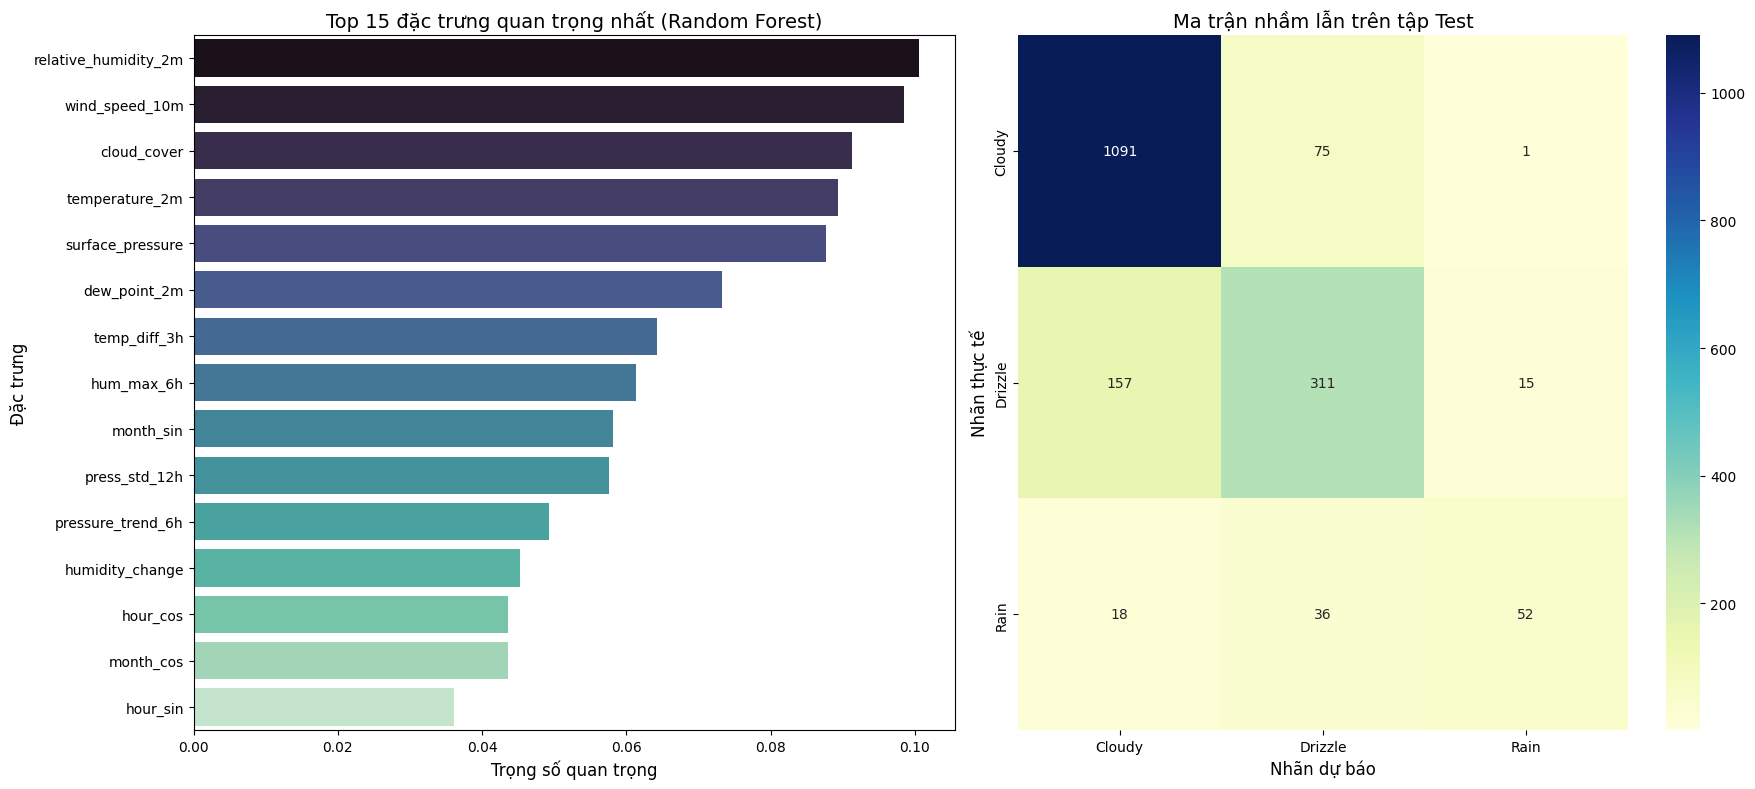


Báo cáo phân loại chi tiết (Classification Report):
              precision    recall  f1-score   support

      Cloudy       0.86      0.93      0.90      1167
     Drizzle       0.74      0.64      0.69       483
        Rain       0.76      0.49      0.60       106

    accuracy                           0.83      1756
   macro avg       0.79      0.69      0.73      1756
weighted avg       0.82      0.83      0.82      1756



In [37]:
# 6. Trực quan hóa kết quả bằng Matplotlib và Seaborn
plt.figure(figsize=(18, 8))

# Biểu đồ 1: Tầm quan trọng đặc trưng (Feature Importance)
# Tính toán mức độ đóng góp của từng đặc trưng vào việc giảm độ tinh khiết (Gini impurity)
plt.subplot(1, 2, 1)
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

sns.barplot(x=importances[indices][:15], y=feature_names[indices][:15], palette='mako')
plt.title('Top 15 đặc trưng quan trọng nhất (Random Forest)', fontsize=14)
plt.xlabel('Trọng số quan trọng', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)

# Biểu đồ 2: Ma trận nhầm lẫn (Confusion Matrix) Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn trên tập Test', fontsize=14)
plt.xlabel('Nhãn dự báo', fontsize=12)
plt.ylabel('Nhãn thực tế', fontsize=12)

plt.tight_layout()
plt.show()

# Hiển thị báo cáo phân loại chi tiết cho từng lớp
print("\nBáo cáo phân loại chi tiết (Classification Report):")
print(classification_report(y_test, y_pred, target_names=class_names))

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def call_metrics_report(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Hàm tính toán và hiển thị các chỉ số cho cả 3 tập dữ liệu dựa trên model được truyền vào.
    """
    # Danh sách các tập dữ liệu để lặp qua
    datasets = [
        ('Train', X_train, y_train),
        ('Validation', X_val, y_val),
        ('Test', X_test, y_test)
    ]
    
    results = []
    
    for name, X_set, y_true in datasets:
        # Thực hiện dự đoán
        y_pred_set = model.predict(X_set)
        
        # Tính toán các chỉ số chuyên sâu
        metrics = {
            'Dataset': name,
            'Accuracy': accuracy_score(y_true, y_pred_set),
            'Weighted Precision': precision_score(y_true, y_pred_set, average='weighted', zero_division=0),
            'Weighted Recall': recall_score(y_true, y_pred_set, average='weighted', zero_division=0),
            'Weighted F1-score': f1_score(y_true, y_pred_set, average='weighted', zero_division=0)
        }
        results.append(metrics)
    
    # Chuyển kết quả thành DataFrame để hiển thị bảng
    results_df = pd.DataFrame(results).set_index('Dataset')
    
    print("\n" + "="*25 + " BẢNG TỔNG HỢP CHỈ SỐ " + "="*25)
    display(results_df.round(4)) # Sử dụng display để bảng hiện đẹp trong Jupyter
    print("="*72 + "\n")
    
    return results_df

# --- GỌI HÀM VỚI BIẾN BEST_MODEL CỦA BẠN ---
# Vì bạn đã scale trực tiếp vào X_train, X_val, X_test ở bước trước, 
# nên ta truyền trực tiếp các biến này vào.
metrics_summary = call_metrics_report(best_model, X_train, y_train, X_val, y_val, X_test, y_test)


========================= BẢNG TỔNG HỢP CHỈ SỐ =========================


,Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score
Dataset,,,,
Train,0.9961,0.9961,0.9961,0.9961
Validation,0.8302,0.8241,0.8302,0.8249
Test,0.8280,0.8216,0.8280,0.8211



==================== BẢNG CHỈ SỐ: HUẤN LUYỆN (TRAIN) ====================


,precision,recall,f1-score,support
Cloudy,0.9998,0.9953,0.9975,8169.0000
Drizzle,0.9900,0.9970,0.9935,3383.0000
Rain,0.9840,1.0000,0.9919,738.0000
accuracy,0.9961,0.9961,0.9961,0.9961
macro avg,0.9913,0.9975,0.9943,12290.0000
weighted avg,0.9961,0.9961,0.9961,12290.0000


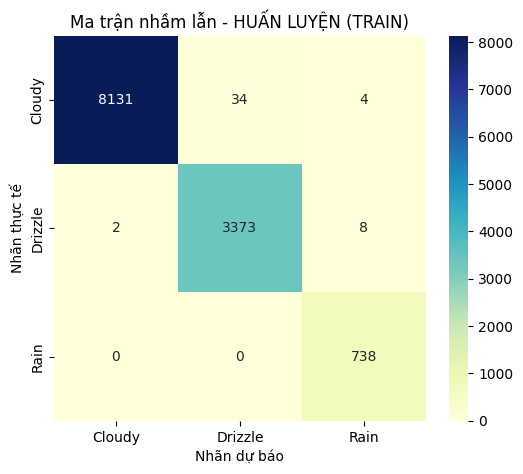

--------------------------------------------------------------------------------

==================== BẢNG CHỈ SỐ: KIỂM ĐỊNH (VALIDATION) ====================


,precision,recall,f1-score,support
Cloudy,0.8664,0.9310,0.8975,2333.0000
Drizzle,0.7363,0.6381,0.6837,967.0000
Rain,0.7590,0.5972,0.6684,211.0000
accuracy,0.8302,0.8302,0.8302,0.8302
macro avg,0.7872,0.7221,0.7499,3511.0000
weighted avg,0.8241,0.8302,0.8249,3511.0000


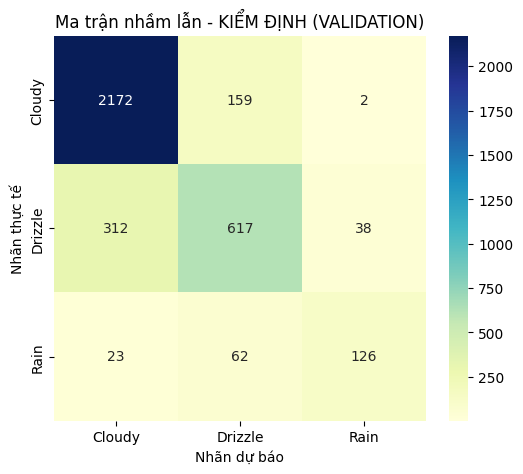

--------------------------------------------------------------------------------

==================== BẢNG CHỈ SỐ: KIỂM TRA (TEST) ====================


,precision,recall,f1-score,support
Cloudy,0.8618,0.9349,0.8968,1167.000
Drizzle,0.7370,0.6439,0.6873,483.000
Rain,0.7647,0.4906,0.5977,106.000
accuracy,0.8280,0.8280,0.8280,0.828
macro avg,0.7878,0.6898,0.7273,1756.000
weighted avg,0.8216,0.8280,0.8211,1756.000


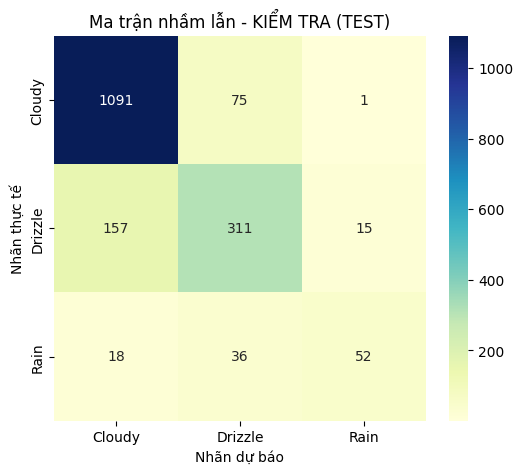

--------------------------------------------------------------------------------


In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_and_plot_separately(model, X_train, y_train, X_val, y_val, X_test, y_test, class_names):
    """
    Hàm xuất bảng chỉ số riêng biệt và vẽ ma trận nhầm lẫn riêng biệt cho từng tập.
    """
    datasets = [
        ("HUẤN LUYỆN (TRAIN)", X_train, y_train),
        ("KIỂM ĐỊNH (VALIDATION)", X_val, y_val),
        ("KIỂM TRA (TEST)", X_test, y_test)
    ]
    
    for name, X, y in datasets:
        # 1. Tính toán dự báo
        y_pred = model.predict(X)
        
        # 2. Xuất bảng chỉ số (Classification Report) dạng DataFrame để nhìn cho rõ
        print(f"\n" + "="*20 + f" BẢNG CHỈ SỐ: {name} " + "="*20)
        report_dict = classification_report(y, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report_dict).transpose()
        display(report_df.round(4)) # Hiển thị bảng đẹp
        
        # 3. Vẽ biểu đồ Confusion Matrix riêng cho tập này
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Ma trận nhầm lẫn - {name}')
        plt.xlabel('Nhãn dự báo')
        plt.ylabel('Nhãn thực tế')
        plt.show()
        print("-" * 80)

# --- THỰC THI ---
evaluate_and_plot_separately(
    best_model, 
    X_train, y_train, 
    X_val, y_val, 
    X_test, y_test, 
    class_names=class_names
)